# First Partial Interpretation (1920s - 70s)

Nothing here is final, and we don't yet have the 1980s or 90s at all.

But we can start to see the basic shape of some results.


In [63]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

### Loading the needed data

I ran the novelty/transience calculations by decade, using a different batch job for 'kld' (topic model) and 'cosine' (embedding) calculations in each decade.

We need to concatenate all those files into one data frame and create a ```logcitations``` column.

In [73]:
# Create the dataframe we'll analyze

embedding_dfs = []
topicmodel_dfs = []

for decade in range(20, 90, 10):
    e_df = pd.read_csv('precocity_cosine_19' + str(decade) + 's_docs.tsv', sep = '\t')
    tm_df = pd.read_csv('precocity_kld_19' + str(decade) + 's_docs.tsv', sep = '\t')
    embedding_dfs.append(e_df)
    topicmodel_dfs.append(tm_df)

embeddings = pd.concat(embedding_dfs, axis = 0)
topicmodels = pd.concat(topicmodel_dfs, axis = 0)

multi_index_columns = ['docid', 'fraction_compared', 'filtered', 'time_radius', 'chunks_used']

topicmodels.set_index(multi_index_columns, inplace=True)
embeddings.set_index(multi_index_columns, inplace=True)

# Rename columns in 'embeddings' DataFrame
embeddings.rename(columns={'novelty': 'embed_novelty', 
                           'transience': 'embed_transience', 
                           'precocity': 'embed_precocity'}, inplace=True)

print('Initial stage: ', embeddings.shape, topicmodels.shape)

# Select the columns we want to add from 'embeddings'
columns_to_add = ['embed_novelty', 'embed_transience', 'embed_precocity']

# Create 'data' DataFrame by joining selected columns from 'embeddings' with 'topicmodels'
data = topicmodels.join(embeddings[columns_to_add], how = 'inner')

print('Intermediate stage: ', data.shape)

data.reset_index(level=['fraction_compared', 'filtered', 'time_radius', 'chunks_used'], inplace=True)

meta = pd.read_csv('../metadata/litstudies/LitMetadataWithS2.tsv', sep = '\t')
meta = meta.loc[~pd.isnull(meta.paperId), : ]
meta.set_index('paperId', inplace = True)

data = data.join(meta['new_cite_count'], how='inner')
data['logcitations'] = np.log(data.new_cite_count + 1)

print('Final stage should be the same:', data.shape)
data.head()


Initial stage:  (387792, 5) (387792, 5)
Intermediate stage:  (387792, 8)
Final stage should be the same: (387792, 14)


,fraction_compared,filtered,time_radius,chunks_used,date,num_chunks,precocity,novelty,transience,embed_novelty,embed_transience,embed_precocity,new_cite_count,logcitations
000041afdc91612fa3c16a31e6381b1dfcf5b69b,1.0,True,10,1.00,1959,11,-0.093936,5.733958,5.827894,0.210611,0.210563,0.000048,1,0.693147
000041afdc91612fa3c16a31e6381b1dfcf5b69b,1.0,True,10,0.25,1959,11,-0.077704,5.808551,5.886255,0.209294,0.208335,0.000958,1,0.693147
000041afdc91612fa3c16a31e6381b1dfcf5b69b,1.0,True,20,1.00,1959,11,-0.147078,5.724905,5.871983,0.211601,0.210379,0.001222,1,0.693147
000041afdc91612fa3c16a31e6381b1dfcf5b69b,1.0,True,20,0.25,1959,11,-0.117383,5.595826,5.713209,0.210309,0.207506,0.002803,1,0.693147
000041afdc91612fa3c16a31e6381b1dfcf5b69b,1.0,False,10,1.00,1959,11,-0.093936,5.733958,5.827894,0.210611,0.210563,0.000048,1,0.693147


### How strength of correlation varies using different methods

In this section we're exploring the contrast between topic-model and GTE-embedding representations of the timeline, and simultaneously exploring options for ```fraction_compared``` and ```chunks_used.```

The fraction_compared indicates whether we *compared* a chunk to all chunks in a past or future year, or only to the 5% of most similar chunks.

The chunks_used option affects the way we relate chunks to the documents (articles) they represent. We could average all chunks in a document, or only the top 25% of most "precocious" chunks.

The other options we explored were a 10-yr or 20-yr time radius, and filtering for text-reuse and author-overlap (which we could set on or off). In the table below we use a 20-yr window plus filtering, which will turn out to be the best choices (see further below for the evidence).

The numbers reported are r from Pearson correlation. Everything here is significant with a very small p value.

In [74]:
correlation_topics = []
correlation_embeds = []

fractions_available = [1.0, 0.05]
chunks_available = [1.0, 0.25]

for frac in fractions_available:
    for chunknum in chunks_available:
        df = data.loc[(data.filtered == True) &
                      (data.time_radius == 20) &
                      (data.fraction_compared == frac) &
                      (data.chunks_used == chunknum), :]
        correlation_t = pearsonr(df.logcitations, df.precocity)
        correlation_e = pearsonr(df.logcitations, df.embed_precocity)
        correlation_topics.append(round(correlation_t[0], 3))
        correlation_embeds.append(round(correlation_e[0], 3))


In [75]:
# Create the DataFrames
df_t = pd.DataFrame({
    'Compare to all': correlation_topics[:2],
    'Most similar 5%': correlation_topics[2:]
}, index=['Average all', 'Average top 25%'])

df_e = pd.DataFrame({
    'Compare to all': correlation_embeds[:2],
    'Most similar 5%': correlation_embeds[2:]
}, index=['Average all', 'Average top 25%'])

# Combine the two DataFrames into a single DataFrame with a multi-level column
combined_df = pd.concat([df_t, df_e], axis=1, keys=['Topic model', 'GTE Embeds'])

combined_df

Topic model                     GTE Embeds                
                Compare to all Most similar 5% Compare to all Most similar 5%
Average all              0.213           0.152          0.055           0.088
Average top 25%          0.236           0.160          0.079           0.117

### An alternate version with a ten-year time radius

In [76]:
correlation_topics = []
correlation_embeds = []

fractions_available = [1.0, 0.05]
chunks_available = [1.0, 0.25]

for frac in fractions_available:
    for chunknum in chunks_available:
        df = data.loc[(data.filtered == True) &
                      (data.time_radius == 10) &
                      (data.fraction_compared == frac) &
                      (data.chunks_used == chunknum), :]
        correlation_t = pearsonr(df.logcitations, df.precocity)
        correlation_e = pearsonr(df.logcitations, df.embed_precocity)
        correlation_topics.append(round(correlation_t[0], 3))
        correlation_embeds.append(round(correlation_e[0], 3))
        
# Create the DataFrames
df_t = pd.DataFrame({
    'Compare to all': correlation_topics[:2],
    'Most similar 5%': correlation_topics[2:]
}, index=['Average all', 'Average top 25%'])

df_e = pd.DataFrame({
    'Compare to all': correlation_embeds[:2],
    'Most similar 5%': correlation_embeds[2:]
}, index=['Average all', 'Average top 25%'])

# Combine the two DataFrames into a single DataFrame with a multi-level column
combined_df = pd.concat([df_t, df_e], axis=1, keys=['Topic model 10yr', 'GTE Embeds 10 yr'])

combined_df

Topic model 10yr                 GTE Embeds 10 yr  \
                  Compare to all Most similar 5%   Compare to all   
Average all                0.183           0.102            0.037   
Average top 25%            0.209           0.103            0.062   

                                 
                Most similar 5%  
Average all               0.061  
Average top 25%           0.082

### An alternate version unfiltered for text reuse and author overlap

In [77]:
correlation_topics = []
correlation_embeds = []

fractions_available = [1.0, 0.05]
chunks_available = [1.0, 0.25]

for frac in fractions_available:
    for chunknum in chunks_available:
        df = data.loc[(data.filtered == False) &
                      (data.time_radius == 20) &
                      (data.fraction_compared == frac) &
                      (data.chunks_used == chunknum), :]
        correlation_t = pearsonr(df.logcitations, df.precocity)
        correlation_e = pearsonr(df.logcitations, df.embed_precocity)
        correlation_topics.append(round(correlation_t[0], 3))
        correlation_embeds.append(round(correlation_e[0], 3))
        
# Create the DataFrames
df_t = pd.DataFrame({
    'Compare to all': correlation_topics[:2],
    'Most similar 5%': correlation_topics[2:]
}, index=['Average all', 'Average top 25%'])

df_e = pd.DataFrame({
    'Compare to all': correlation_embeds[:2],
    'Most similar 5%': correlation_embeds[2:]
}, index=['Average all', 'Average top 25%'])

# Combine the two DataFrames into a single DataFrame with a multi-level column
combined_df = pd.concat([df_t, df_e], axis=1, keys=['Topic model unfiltered', 'GTE Embeds unfiltered'])

combined_df

Topic model unfiltered                 GTE Embeds unfiltered  \
                        Compare to all Most similar 5%        Compare to all   
Average all                      0.212           0.148                 0.055   
Average top 25%                  0.235           0.156                 0.079   

                                 
                Most similar 5%  
Average all               0.086  
Average top 25%           0.115

### A full multiple regression on the data

Maybe the relationship is not linear or would benefit from controlling for date of publication.

In [87]:
best = data.loc[(data.fraction_compared == 1.0) & 
                (data.time_radius == 20) &
                (data.filtered == True) &
                (data.chunks_used == 0.25), :]

X = pd.DataFrame({'topic': best.precocity, 'embed': best.embed_precocity,
                  'topic2': best.precocity ** 2, 'embed2': best.embed_precocity ** 2,
                  'topicinteract': best.precocity * (best.date - 1919),
                  'embedinteract': best.embed_precocity * (best.date - 1919),
                  'pub_year': best.date, 'intercept': 1})
y = best.logcitations
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     257.1
Date:                Tue, 28 Nov 2023   Prob (F-statistic):               0.00
Time:                        11:15:29   Log-Likelihood:                -36813.
No. Observations:               24237   AIC:                         7.364e+04
Df Residuals:                   24229   BIC:                         7.371e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
topic            -0.0698      0.386     -0.181

In [86]:
math.sqrt(.069)

0.26267851073127396

#### Interpretation of the regression

Adding the 1980s has changed a lot — which is a reminder that the "multicollinearity" issue makes this hard to interpret. 

In this version of the regression, it looks like the embeddings do add something beyond the topic model — and also looks like the relationship is not strictly linear. More analysis is probably called for, but in this version the strongest predictors are topic-precocity's *interaction* with publication date, publication date itself, and embed-precocity *squared*.

Precocity plus publication year together can explain ~7% of the variance in logcitations. That's not huge, but we really don't expect citation count to directly reflect textual innovation, and the goal here is not to find the variables that most strongly affect citation count. (We already know what those are: they are, of course, existing author prominence, prominence of venue, and so on.)

It's interesting that there's a relationship to textual novelty at all -- and more importantly the relationship to social impact can help us select a preferred metric for textual innovation. That's the actual point of what we're doing.

### How this relationship varies across time, for the topic model

In [80]:
upperbound = []
lowerbound = []
medianpoint = []

for centeryear in range(1925, 1986):
    df = best.loc[(best.date >= centeryear - 5) &
                  (best.date <= centeryear + 5), :]
    correlations = []
    for i in range(1000):
        numrows = df.shape[0]
        sample_df = df.sample(numrows, replace = True)
        correlations.append(pearsonr(sample_df.logcitations, sample_df.precocity)[0])
    correlations.sort()
    lowerbound.append(correlations[24])
    upperbound.append(correlations[974])
    medianpoint.append(correlations[499])   

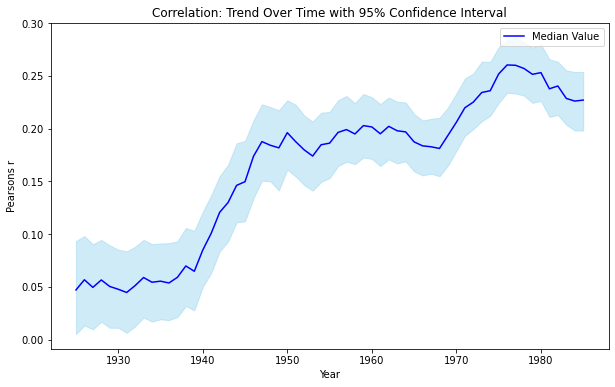

In [81]:
# Sample DataFrame
plotdata = {
    'year': range(1925, 1986),
    'median_value': medianpoint,  # replace with your median values
    'upper_bound': upperbound,    # replace with your upper bound values
    'lower_bound': lowerbound     # replace with your lower bound values
}
df = pd.DataFrame(plotdata)

# Plotting
plt.figure(figsize=(10, 6))

# Shaded ribbon (confidence interval)
plt.fill_between(df['year'], df['lower_bound'], df['upper_bound'], color='skyblue', alpha=0.4)

# Median value trend line
plt.plot(df['year'], df['median_value'], color='blue', label='Median Value')

# Labels and Title
plt.xlabel('Year')
plt.ylabel('Pearsons r')
plt.title('Correlation: Trend Over Time with 95% Confidence Interval')
plt.legend()

# Show Plot
plt.show()

### How it varies across time for embeddings

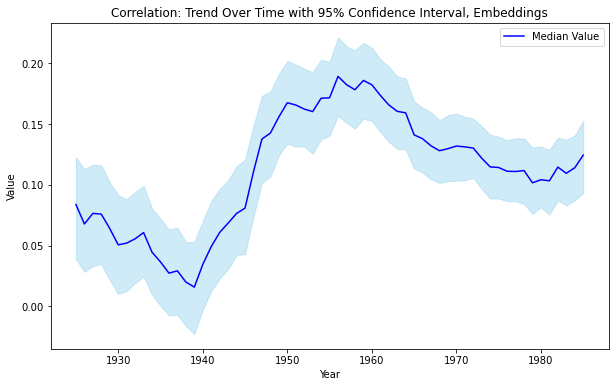

In [84]:
bestforembeds = data.loc[(data.fraction_compared == 0.05) & 
                (data.time_radius == 20) &
                (data.filtered == True) &
                (data.chunks_used == 0.25), :]


upperbound = []
lowerbound = []
medianpoint = []

for centeryear in range(1925, 1986):
    df = best.loc[(bestforembeds.date >= centeryear - 5) &
                  (bestforembeds.date <= centeryear + 5), :]
    correlations = []
    for i in range(1000):
        numrows = df.shape[0]
        sample_df = df.sample(numrows, replace = True)
        correlations.append(pearsonr(sample_df.logcitations, sample_df.embed_precocity)[0])
    correlations.sort()
    lowerbound.append(correlations[24])
    upperbound.append(correlations[974])
    medianpoint.append(correlations[499])

# Sample DataFrame
plotdata = {
    'year': range(1925, 1986),
    'median_value': medianpoint,  # replace with your median values
    'upper_bound': upperbound,    # replace with your upper bound values
    'lower_bound': lowerbound     # replace with your lower bound values
}
df = pd.DataFrame(plotdata)

# Plotting
plt.figure(figsize=(10, 6))

# Shaded ribbon (confidence interval)
plt.fill_between(df['year'], df['lower_bound'], df['upper_bound'], color='skyblue', alpha=0.4)

# Median value trend line
plt.plot(df['year'], df['median_value'], color='blue', label='Median Value')

# Labels and Title
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Correlation: Trend Over Time with 95% Confidence Interval, Embeddings')
plt.legend()

# Show Plot
plt.show()

### Deprecated

In [28]:
# guide code borrowed from GPT-4!

# Creating a 2x2 DataFrame for each state of Var3
# Here 'A' and 'B' will be the row indices, and 'C' and 'D' will be the column indices

# Define the accuracy statistics for each model configuration
# Assuming the order of the stats is the same as the multi-index provided previously
accuracy_stats_e = [0.95, 0.89, 0.96, 0.88]  # Stats where Var3 is 'E'
accuracy_stats_f = [0.92, 0.87, 0.91, 0.85]  # Stats where Var3 is 'F'

# Create the DataFrames
df_e = pd.DataFrame({
    'C': accuracy_stats_e[:2],
    'D': accuracy_stats_e[2:]
}, index=['A', 'B'])

df_f = pd.DataFrame({
    'C': accuracy_stats_f[:2],
    'D': accuracy_stats_f[2:]
}, index=['A', 'B'])

# Combine the two DataFrames into a single DataFrame with a multi-level column
combined_df = pd.concat([df_e, df_f], axis=1, keys=['Var3=E', 'Var3=F'])

combined_df


Var3=E       Var3=F      
       C     D      C     D
A   0.95  0.96   0.92  0.91
B   0.89  0.88   0.87  0.85